<a href="https://colab.research.google.com/github/mikeacquaviva/APS360-Leukaemia-Classification/blob/main/cnn_leukemia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
import time
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
data_dir = ("/content/gdrive/MyDrive/APS360/baseline/svm_images")
classes = ['benign', 'early', 'pre', 'pro']
data_transform = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor()])
data = datasets.ImageFolder(data_dir, transform = data_transform)
train, val, test = random_split(data, [240, 80, 80], generator=torch.Generator().manual_seed(0)) #adding seed such that it produces the same data set each time
# print out some data stats
print('Num training images: ', len(train))
print('Num validation images: ', len(val))
print('Num test images: ', len(test))

Num training images:  240
Num validation images:  80
Num test images:  80


In [6]:
# define dataloader parameters
batch_size = 32
num_workers = 0

# prepare data loaders
train_loader = 0
val_loader = 0
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=27, 
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=27, 
                                          num_workers=num_workers, shuffle=True)
print(len(train_loader))

9


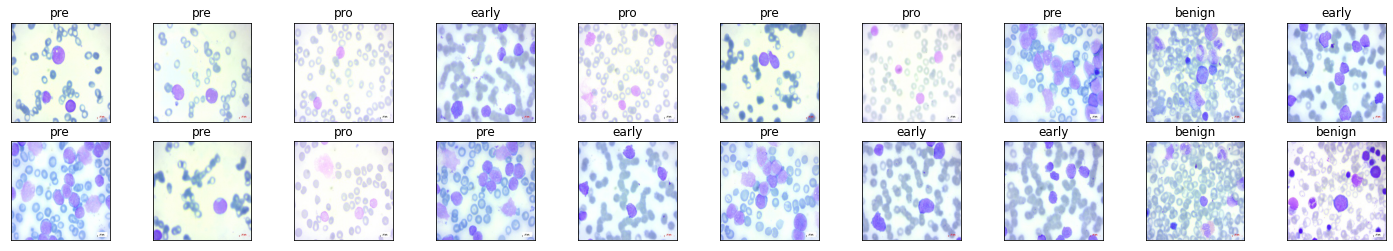

In [7]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent

torch.manual_seed(0) # set the random seed

In [9]:
def get_data_loader(target_classes, batch_size):
  classes = ['benign', 'early', 'pre', 'pro']
  

In [10]:
#Convolutional Neural Network Architecture
class CNN_MNISTClassifier(nn.Module):
    def __init__(self):
        super(CNN_MNISTClassifier, self).__init__()
        self.name = "cnn"
        self.conv1 = nn.Conv2d(3, 5, 3) #in_channels, out_chanels, kernel_size, 
        #convolution neural network and have to specify the number of inner terminals and define the kernel size.
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride  
        #shift the entire image by 2 kernsls
        self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(10 * 53 * 53, 32) 
        self.fc2 = nn.Linear(32, 4) #which letter from a-i as the options for output, so 9 outputs 

    def forward(self, x):
        y = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(y))) #flatten the layer
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc2(x)
        return x
    
    print('Convolutional Neural Network Architecture Done')

Convolutional Neural Network Architecture Done


In [11]:
#helper function; label, evaluate



def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        #labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

In [13]:
def get_accuracy(model, data):

    correct = 0
    total = 0
    for imgs, labels in data:
        print(imgs.size())
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [14]:
from torch.utils.data import DataLoader, Dataset
def train(model, batch_size, learning_rate, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    epoch = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model,train_loader)) # compute training accuracy 
        val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
            #n += 1
        print(epoch, "acc:", train_acc[epoch])
            

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([24, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([26, 3, 224, 224])
0 acc: 0.2791666666666667
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([24, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([26, 3, 224, 224])
1 acc: 0.2791666666666667
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3,

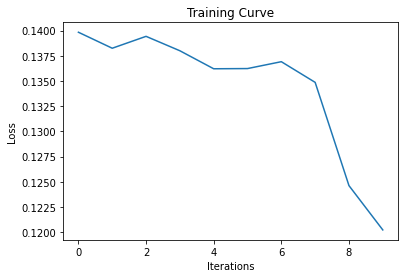

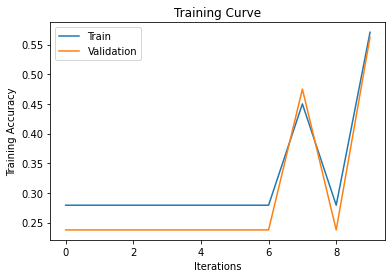

Final Training Accuracy: 0.5708333333333333
Final Validation Accuracy: 0.5625


In [15]:
net = CNN_MNISTClassifier()

train(net, batch_size = 10, learning_rate = 0.01, num_epochs=10)

torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([24, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([26, 3, 224, 224])
0 acc: 0.2791666666666667
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([24, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([26, 3, 224, 224])
1 acc: 0.2791666666666667
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([27, 3,

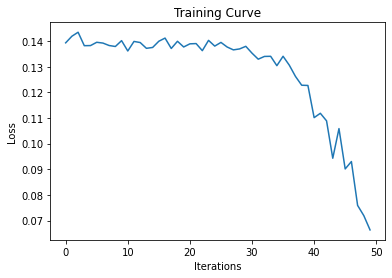

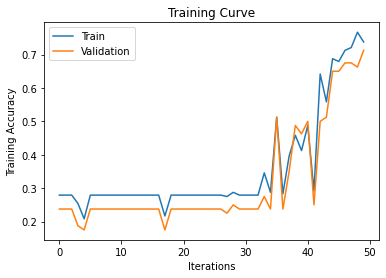

Final Training Accuracy: 0.7375
Final Validation Accuracy: 0.7125


In [18]:
net = CNN_MNISTClassifier()
train(net, batch_size = 10, learning_rate=0.001, num_epochs=50)